In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/option_features.csv')
data = data.sort_values(by=['ticker', 'date'])

In [6]:
train_mask = 'date.between("2023-01-01", "2023-07-31")'
val_mask = 'date.between("2023-08-01", "2023-09-30")'
test_mask = 'date > "2023-10-01"'

train_data = data.query(train_mask)
val_data = data.query(val_mask)
test_data = data.query(test_mask)

In [7]:
from scripts.data_utils import get_timeseries


X_train_ts, y_train = get_timeseries(train_data)
X_val_ts, y_val = get_timeseries(val_data)
X_test_ts, y_test = get_timeseries(test_data)

In [8]:
X_train = X_train_ts[:,-1,:]
X_val = X_val_ts[:,-1,:]
X_test = X_test_ts[:,-1,:]

X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# Black-Scholes model

In [8]:
from scipy.stats import norm

In [71]:
def black_scholes(row):
    TTM, strike, spot, rate, vol = row
    d1 = (np.log(spot / strike) + (rate + 0.5 * vol**2) * TTM) / (vol * np.sqrt(TTM))
    d2 = d1 - vol * np.sqrt(TTM)
    return spot * norm.cdf(d1) - strike * np.exp(-rate * TTM) * norm.cdf(d2)

y_bs = np.array([black_scholes(row) for row in X_test])

# Catboost

In [51]:
# !pip install catboost
from catboost import CatBoostRegressor

In [52]:
model_cb = CatBoostRegressor(verbose=0)
model_cb.fit(X_train_val, y_train_val.reshape(-1,1))

y_boost = model_cb.predict(X_test)

# MLP

In [7]:
from scripts.train_utils import train
from scripts.data_utils import DataSet
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


torch.manual_seed(0)

In [53]:
def normalize(sample):
    """
    Min-max normalization to convert sample to [0, 1] range
    """
    return (sample - m)/d
def denormalize(sample):
    """
    Denormalize sample from [0, 1] to initial range
    """
    return sample * d + m


m, d = y_train.mean(), y_train.std()

In [54]:
y_train_norm = normalize(y_train)
y_val_norm = normalize(y_val)

train_dataset = DataSet((X_train, y_train_norm))
val_dataset = DataSet((X_val, y_val_norm))

train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10000)

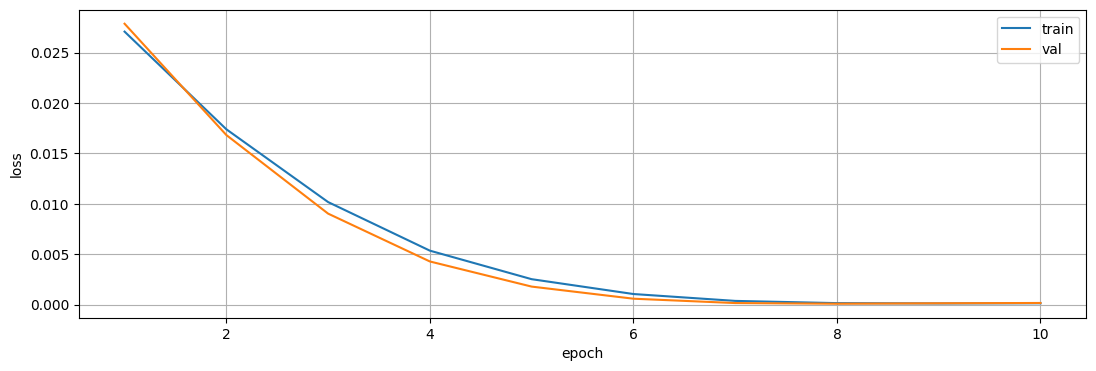

In [61]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp = MLP().to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

train_mlp(mlp, optimizer, train_loader, val_loader, 10)

In [62]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_mlp = mlp(X_test_tensor)
y_mlp = denormalize(y_mlp.detach().cpu().numpy())

# RNN

In [37]:

class RNN(nn.Module):
    def __init__(self, n_feature: int = 5, hidden_size: int = 64, rnn_layers: int =3):
        """
        :param n_feature: dimensionality of features
        :param hidden_size: dimensionality of hidden state
        :param rnn_layers: number of layers in RNN
        """
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=n_feature,
                            hidden_size=hidden_size,
                            num_layers=rnn_layers)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, features) -> torch.Tensor:
        """
        Compute forward pass through the model and
        return estimations of future option payout
        :param features: LongTensor of option features
        :return: FloatTensor of logits of shape (batch_size,)
        """

        output_tmp, h = self.rnn(features)
        output = self.linear(output_tmp.mean(axis=1))

        return output

In [42]:
y_train_norm = normalize(y_train)
y_val_norm = normalize(y_val)

train_ts_dataset = DataSet((X_train_ts, y_train_norm))
val_ts_dataset = DataSet((X_val_ts, y_val_norm))

train_ts_loader = DataLoader(train_ts_dataset, batch_size=128, shuffle=True)
val_ts_loader = DataLoader(val_ts_dataset, batch_size=64)

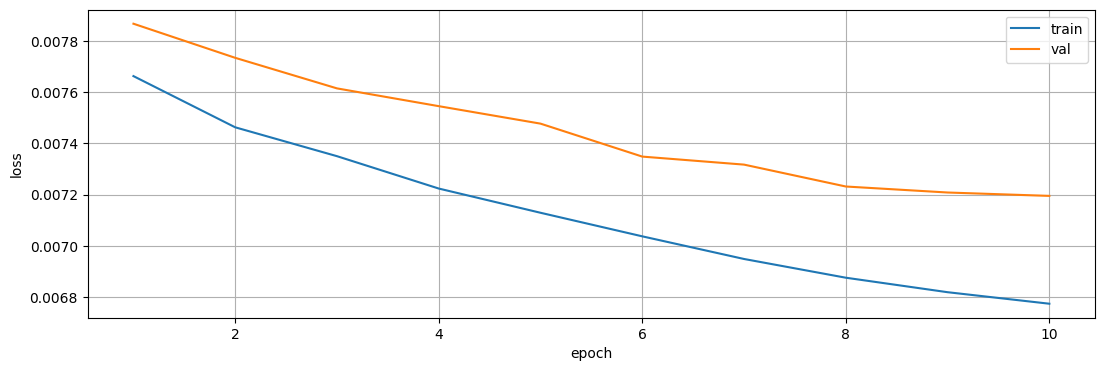

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rnn = RNN().to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=5e-6)
train(rnn, optimizer, train_ts_loader, val_ts_loader, 10)

In [80]:
X_test_ts_tensor = torch.tensor(X_test_ts, dtype=torch.float32).to(device)

y_rnn = rnn(X_test_ts_tensor)
y_rnn = denormalize(y_rnn.detach().cpu().numpy()).flatten()

# Evaluation

In [96]:
from scripts.evaluation import Metrics
clf = Metrics(y_test, X_test, y_bs, y_boost, y_mlp, y_rnn)
clf.get_full_metrics()
clf.get_maturity_metrics()